# Forecasting Task

## What is in this notebook

This notebook sets up the basic structure and investigates features and tree models. It also investigates statistical forecasting methods such as crostons and single exponential smoothing. The last section calculates matrices and plots the forecast. There is no cross-validation.

## Imports and Load Data

In [11]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [12]:
cwd = os.getcwd()
DATA_DIR = os.path.join(cwd, '..', 'data')
INT_DATA_DIR = os.path.join(cwd, '..', 'data', 'interim')
RAW_DATA_DIR = os.path.join(cwd, '..', 'data', 'raw')

In [13]:
def load_data():
    """Load all required CSV files"""
    consumptions = pd.read_csv(os.path.join(RAW_DATA_DIR,'average_consumption.csv'))
    consumptions['validfrom'] = pd.to_datetime(consumptions['validfrom'])
    consumptions = consumptions.sort_values(by=["validfrom"])
    
    return consumptions

In [14]:
consumptions_df = load_data()

In [15]:
consumptions_df.head()

,avg,validfrom,air_temp,azimuth,cloud_opacity,dewpoint_temp,dhi,dni,ghi,gti,...,relative_humidity,snow_depth,snow_soiling_rooftop,snow_soiling_ground,wind_direction_100m,wind_direction_10m,wind_speed_100m,wind_speed_10m,zenith,price
0,0.478159,2024-01-01 00:00:00+00:00,2.86,-33.056371,79.144556,2.0,0.0,0.0,0.0,0.0,...,91.815135,3.37,7.192278,5.263320,280.044015,274.067954,6.249884,3.326795,151.919691,0.01
1,0.487376,2024-01-01 00:15:00+00:00,2.90,-39.450193,78.138996,2.0,0.0,0.0,0.0,0.0,...,91.925483,3.37,7.264865,5.227799,280.312741,274.007722,6.253359,3.357220,150.537452,0.01
2,0.478889,2024-01-01 00:30:00+00:00,2.96,-45.406950,76.868958,2.0,0.0,0.0,0.0,0.0,...,92.075985,3.32,7.145174,5.183012,280.753668,273.718147,6.255521,3.380077,148.705019,0.01
3,0.481105,2024-01-01 00:45:00+00:00,3.01,-50.913514,77.183012,2.0,0.0,0.0,0.0,0.0,...,92.218533,3.32,7.217761,5.147490,273.484170,266.280309,6.322239,3.421390,146.810811,0.01
4,0.495708,2024-01-01 01:00:00+00:00,3.01,-55.932046,79.121699,2.0,0.0,0.0,0.0,0.0,...,92.340386,3.30,7.217761,5.134363,272.935907,265.764479,6.282085,3.390425,144.857143,0.02


In [16]:
consumptions_df.tail()

,avg,validfrom,air_temp,azimuth,cloud_opacity,dewpoint_temp,dhi,dni,ghi,gti,...,relative_humidity,snow_depth,snow_soiling_rooftop,snow_soiling_ground,wind_direction_100m,wind_direction_10m,wind_speed_100m,wind_speed_10m,zenith,price
23413,0.077549,2024-08-31 22:45:00+00:00,20.868,2.293,31.549,15.549,0.0,0.0,0.0,0.0,...,71.958,0.213,0.025,0.01,120.801,171.134,5.369,2.709,123.304,94.78
23414,0.084038,2024-08-31 23:00:00+00:00,20.670,-2.248,31.555,15.556,0.0,0.0,0.0,0.0,...,72.765,0.213,0.024,0.01,120.752,170.908,5.373,2.723,123.203,86.00
23415,0.080813,2024-08-31 23:15:00+00:00,20.564,-6.603,29.781,15.554,0.0,0.0,0.0,0.0,...,73.630,0.214,0.022,0.01,120.889,173.817,5.332,2.709,123.179,86.00
23416,0.078287,2024-08-31 23:30:00+00:00,20.419,-10.998,26.958,15.527,0.0,0.0,0.0,0.0,...,74.503,0.214,0.020,0.01,121.050,157.016,5.288,2.701,122.847,86.00
23417,0.077542,2024-08-31 23:45:00+00:00,20.034,-15.352,26.514,15.524,0.0,0.0,0.0,0.0,...,75.385,0.214,0.019,0.01,115.800,156.734,5.251,2.702,122.182,86.00


## Check if the timeseries is stationary using the Dicky_Fuller Test

In [8]:
print("_ " * 10)
print("\n")

dftest = adfuller(consumptions_df['avg'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
if dftest[1] <= 0.05:
    print("6. STATIONARY")
else:
    print("6. NOT STATIONARY")

print("\n")

_ _ _ _ _ _ _ _ _ _ 


1. ADF :  -16.586764992668353
2. P-Value :  1.8138040736590363e-29
3. Num Of Lags :  46
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 23371
5. Critical Values :
	 1% :  -3.430629834768986
	 5% :  -2.861663678115528
	 10% :  -2.5668358303107137
6. STATIONARY




## Plot the Raw Time Series

In [9]:
consumptions_df["month"] = consumptions_df["validfrom"].dt.month

<Figure size 640x480 with 0 Axes>

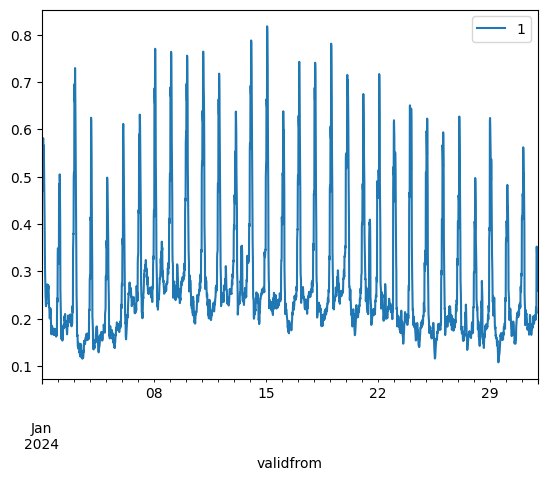

<Figure size 640x480 with 0 Axes>

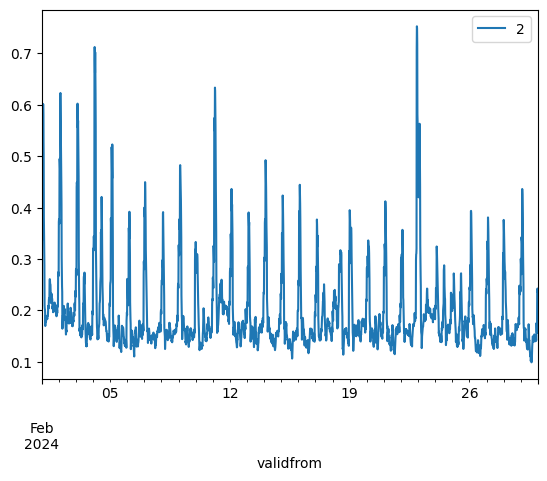

<Figure size 640x480 with 0 Axes>

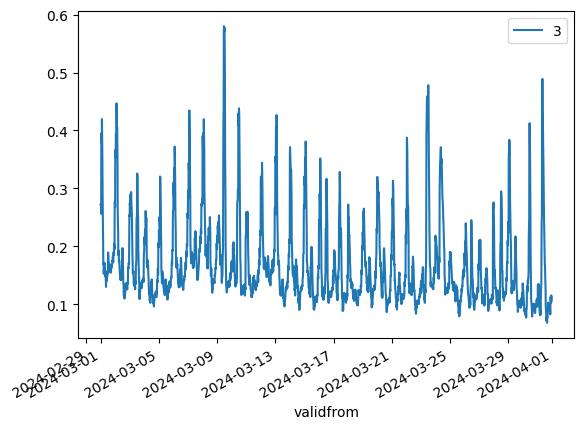

<Figure size 640x480 with 0 Axes>

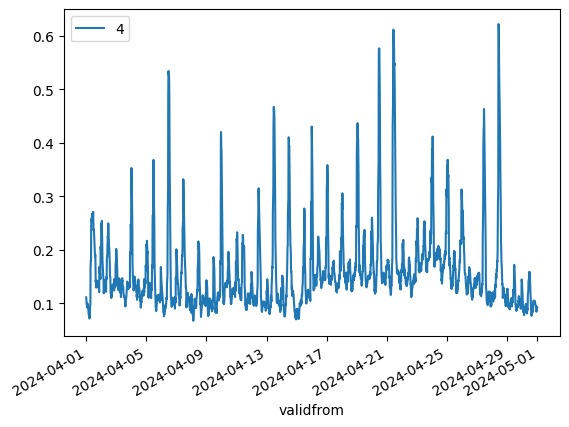

<Figure size 640x480 with 0 Axes>

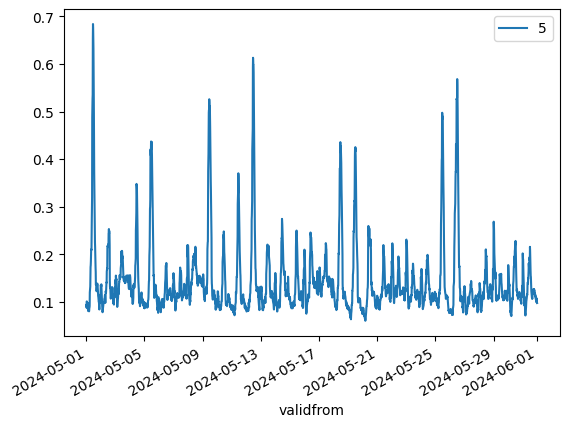

<Figure size 640x480 with 0 Axes>

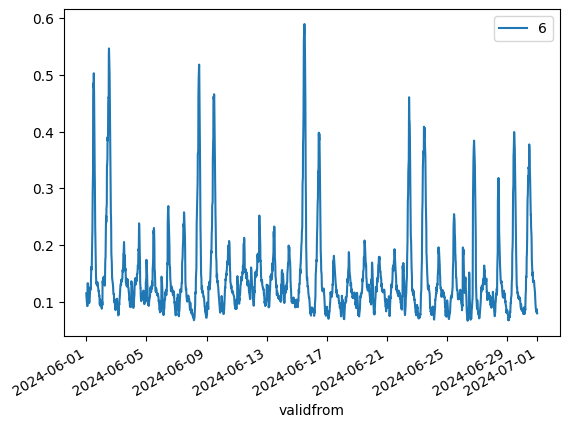

<Figure size 640x480 with 0 Axes>

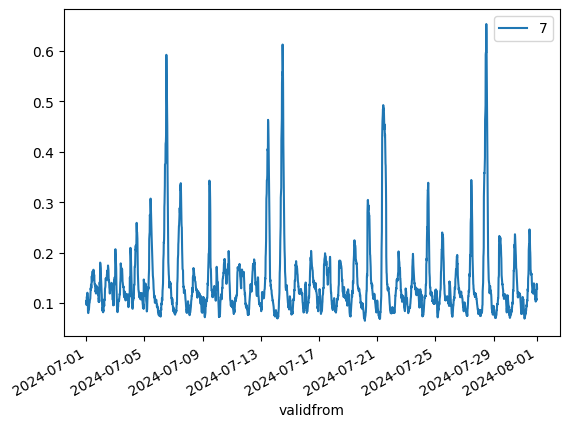

<Figure size 640x480 with 0 Axes>

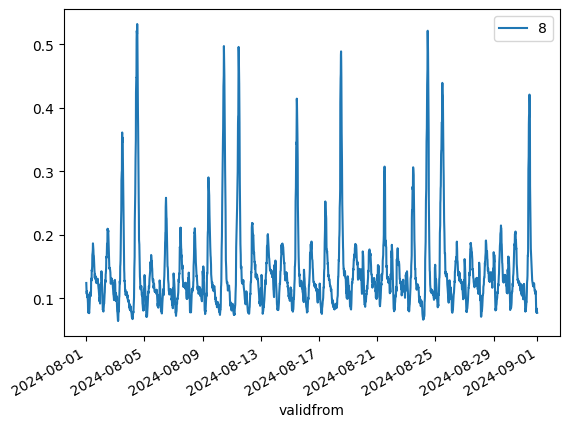

In [10]:
for month in consumptions_df["month"].unique():
    plt.figure()
    consumptions_df[consumptions_df['month']==month].plot(x='validfrom', y = 'avg', label=month)
plt.show()

The graphs all show both cyclic features. 

## Plot Autocorrelation Plots

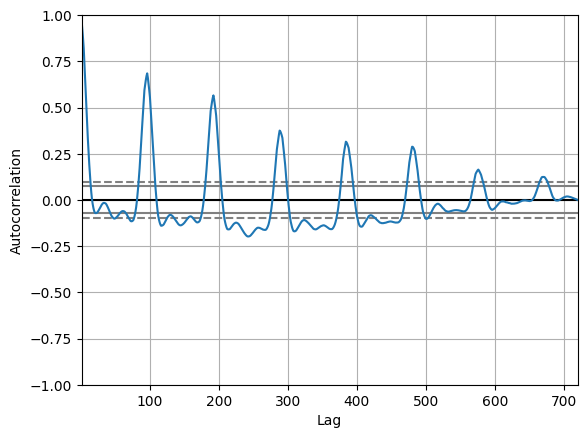

In [11]:
plt.figure()
autocorrelation_plot(consumptions_df['avg'].tolist()[:720])
plt.show()

The plot shows clear periodic spikes in the autocorrelation, roughly every 96 lags. Since 96 lags correspond to:
96×15 minutes = 24 hours. This suggests the data has a strong daily periodicity. Between these periodic peaks, the autocorrelation decreases and oscillates around zero. This behavior indicates that, while there is a daily pattern, the similarity fades as the time difference increases within each cycle. Beyond lag ~700 (~175 hours or ~7 days), the autocorrelation values stabilize near zero, indicating that the long-term dependence fades out.

## Looking at seasonal decomposition

<Figure size 640x480 with 0 Axes>

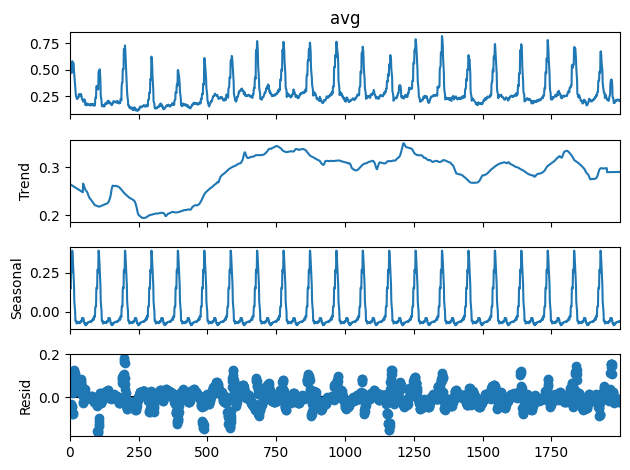

In [12]:
plt.figure()
diff_data = consumptions_df['avg'][0:2000]
result_mul = seasonal_decompose(diff_data, model='additive', extrapolate_trend='freq', period=96)
result_mul.plot()
plt.show()

Strong Daily Seasonality:
The seasonal component confirms a clear daily cycle, likely these are patterns in energy usage (e.g., higher during the day, lower at night).

Gradual Trend:
The trend shows a steady increase in overall consumption, potentially reflecting a growing baseline or changing user behavior over time.

Small Residuals:
The residuals indicate that most of the variability in the data can be explained by the trend and seasonal components.

In [13]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

def forecast_sarima_with_ape(data, time_col='validfrom', response_col='avg', order=(1, 1, 1), seasonal_order=(1, 1, 1, 96), test_size=0.1, subset_size=96*7*4):
    """
    Forecast using SARIMA on a subset of data and calculate Area Percentage Error (APE).
    """
    data[time_col] = pd.to_datetime(data[time_col])
    data = data.set_index(time_col)
    data = data.asfreq('15min')
    if subset_size < len(data):
        data = data.tail(subset_size)

    train_size = int(len(data) * (1 - test_size))
    train, test = data.iloc[:train_size], data.iloc[train_size:]

    model = SARIMAX(
        train[response_col],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    forecast = fitted_model.forecast(steps=len(test))

    actuals = test[response_col]
    ape = np.sum(np.abs(actuals - forecast)) / np.sum(np.abs(actuals))

    return {
        'model': fitted_model,
        'forecast': forecast,
        'ape': ape
    }

data = consumptions_df.copy()
results = forecast_sarima_with_ape(
    data=data,
    time_col='validfrom',
    response_col='avg',
    order=(2, 1, 1),
    seasonal_order=(1, 1, 1, 96),  # 96 for daily seasonality (15-minute intervals)
    test_size=0.2,
    subset_size=96*7*4  # last 4 weeks of data
)

# Print the APE and forecasted values
print("Area Percentage Error (APE):", results['ape'])
print("Forecasted Values:", results['forecast'])


/Users/jabbar/src/awattar/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Area Percentage Error (APE): 0.46672609206927024
Forecasted Values: 2024-08-26 09:30:00+00:00    0.160417
2024-08-26 09:45:00+00:00    0.161561
2024-08-26 10:00:00+00:00    0.181096
2024-08-26 10:15:00+00:00    0.184541
2024-08-26 10:30:00+00:00    0.184403
                               ...   
2024-08-31 22:45:00+00:00    0.020305
2024-08-31 23:00:00+00:00    0.040142
2024-08-31 23:15:00+00:00    0.039076
2024-08-31 23:30:00+00:00    0.037055
2024-08-31 23:45:00+00:00    0.034211
Freq: 15min, Name: predicted_mean, Length: 538, dtype: float64


In [14]:
import matplotlib.pyplot as plt

def plot_forecast_results(train, test, forecast, response_col='avg'):
    """
    Plot the actual and forecasted values for the test set.
    """
    plt.figure(figsize=(14, 7))
    
    # Plot training data
    plt.plot(train.index, train[response_col], label='Training Data', color='blue')
    
    # Plot actual test data
    plt.plot(test.index, test[response_col], label='Actual Test Data', color='green')
    
    # Plot forecasted data
    plt.plot(test.index, forecast, label='Forecasted Data', color='red', linestyle='--')
    
    plt.title('Forecast vs Actuals')
    plt.xlabel('Time')
    plt.ylabel('Consumption')
    plt.legend()
    plt.grid()
    plt.show()


Area Percentage Error (APE): 0.46672609206927024


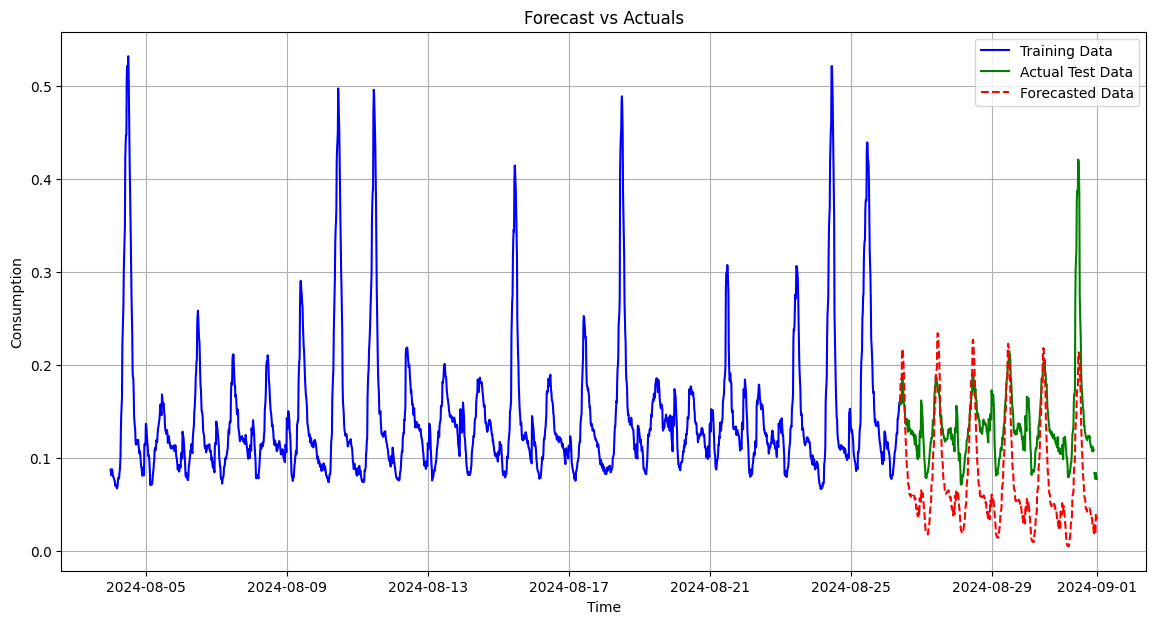

In [15]:
print("Area Percentage Error (APE):", results['ape'])

data['validfrom'] = pd.to_datetime(data['validfrom'])
data = data.set_index('validfrom')
data = data.asfreq('15min')

subset_data = data.tail(96 * 7 * 4)
train_size = int(len(subset_data) * 0.8)
train, test = subset_data.iloc[:train_size], subset_data.iloc[train_size:]
plot_forecast_results(train, test, results['forecast'], response_col='avg')

In [22]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

def forecast_holt_winters_with_ape(data, time_col='validfrom', response_col='avg', seasonal='add', seasonal_periods=96, test_size=0.1, subset_size=96*7*4):
    """
    Forecast using Holt-Winters Exponential Smoothing and calculate Area Percentage Error (APE).
    """
    data[time_col] = pd.to_datetime(data[time_col])
    data = data.set_index(time_col)
    data = data.asfreq('15min') 
    

    if subset_size < len(data):
        data = data.tail(subset_size)
    train_size = int(len(data) * (1 - test_size))
    train, test = data.iloc[:train_size], data.iloc[train_size:]

    # Holt-Winters
    model = ExponentialSmoothing(
        train[response_col],
        seasonal=seasonal,  
        seasonal_periods=seasonal_periods
    )
    fitted_model = model.fit()

    forecast = fitted_model.forecast(steps=len(test))
    
    actuals = test[response_col]
    ape = np.sum(np.abs(actuals - forecast)) / np.sum(np.abs(actuals))

    return {
        'model': fitted_model,
        'forecast': forecast,
        'ape': ape
    }


data = consumptions_df.copy() 
results_holt_winters = forecast_holt_winters_with_ape(
    data=data,
    time_col='validfrom',
    response_col='avg',
    seasonal='add',  
    seasonal_periods=96,  
    test_size=0.1,
    subset_size=96*7*4  
)

# Print the APE and forecasted values
print("Area Percentage Error (APE):", results_holt_winters['ape'])
print("Forecasted Values:", results_holt_winters['forecast'])


Area Percentage Error (APE): 0.17037654596504168
Forecasted Values: 2024-08-29 04:45:00+00:00    0.089994
2024-08-29 05:00:00+00:00    0.094864
2024-08-29 05:15:00+00:00    0.097915
2024-08-29 05:30:00+00:00    0.100770
2024-08-29 05:45:00+00:00    0.104836
                               ...   
2024-08-31 22:45:00+00:00    0.108206
2024-08-31 23:00:00+00:00    0.127032
2024-08-31 23:15:00+00:00    0.126016
2024-08-31 23:30:00+00:00    0.123971
2024-08-31 23:45:00+00:00    0.121590
Freq: 15min, Length: 269, dtype: float64


/Users/jabbar/src/awattar/.conda/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Area Percentage Error (APE): 0.17037654596504168


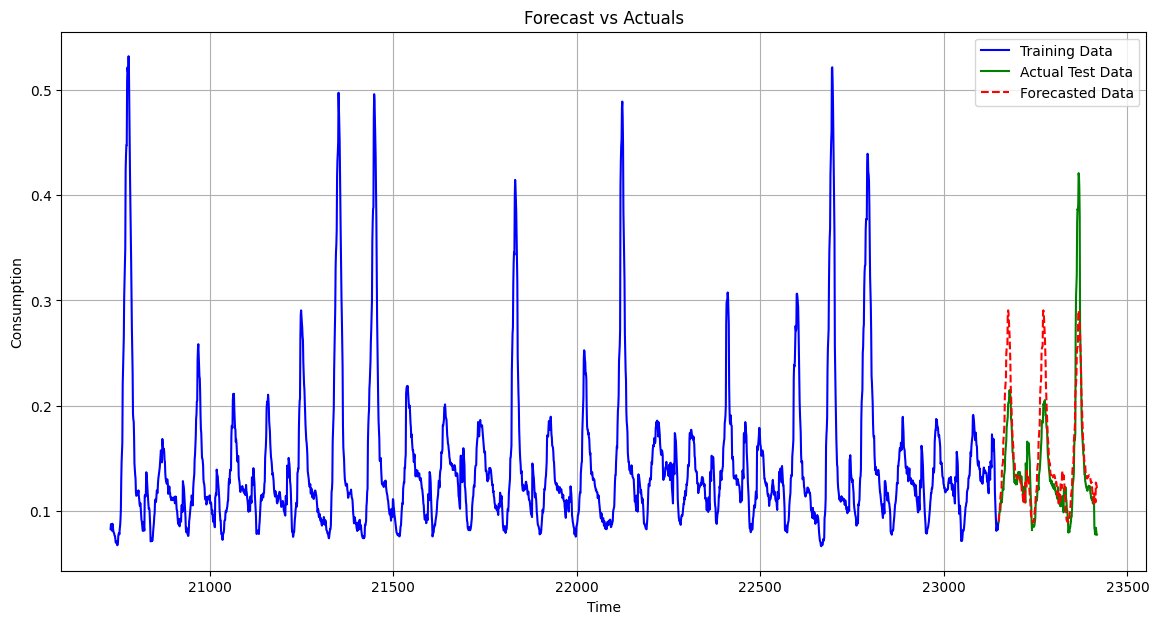

In [24]:
print("Area Percentage Error (APE):", results_holt_winters['ape'])
subset_data = data.tail(96 * 7 * 4)
train_size = int(len(subset_data) * 0.9) 
train, test = subset_data.iloc[:train_size], subset_data.iloc[train_size:]
forecast = results_holt_winters['forecast'][:len(test)]


plot_forecast_results(train, test, forecast, response_col='avg')
